In [1]:
import os
import glob
import numpy as np
import geopandas as gpd
import pandas as pd
import rasterio
from rasterio.transform import from_origin
from rasterio.features import rasterize
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap, BoundaryNorm

In [2]:
UK_SHP = "/Users/hester/Desktop/data/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp"
WDPA_DIRS = [
    "/Users/hester/Desktop/data/Protected areas/WDPA_WDOECM_Jan2026_Public_GBR_shp_0",
    "/Users/hester/Desktop/data/Protected areas/WDPA_WDOECM_Jan2026_Public_GBR_shp_1",
    "/Users/hester/Desktop/data/Protected areas/WDPA_WDOECM_Jan2026_Public_GBR_shp_2"]

In [3]:
countries = gpd.read_file(UK_SHP)

uk = countries.loc[countries.get("ADMIN", "") == "United Kingdom"].copy()
if uk.empty and "ISO_A3" in countries.columns:
    uk = countries.loc[countries["ISO_A3"] == "GBR"].copy()
if uk.empty:
    raise ValueError("没在 ne_10m_admin_0_countries 里筛到 UK（United Kingdom/GBR），请检查字段名。")

uk = uk.dissolve() 
uk = uk.set_geometry("geometry")

In [4]:
wdpa_list = []
for d in WDPA_DIRS:
    shp_files = glob.glob(os.path.join(d, "*.shp"))
    for shp in shp_files:
        wdpa_list.append(gpd.read_file(shp))

wdpa = gpd.GeoDataFrame(pd.concat(wdpa_list, ignore_index=True), crs=wdpa_list[0].crs)

wdpa = wdpa[wdpa.geometry.notnull()].copy()
wdpa = wdpa[wdpa.geom_type.isin(["Polygon", "MultiPolygon"])].copy()

In [5]:
for col in ["ISO3", "ISO3_CODE", "ISO3C", "ISO3_"]:
    if col in wdpa.columns:
        wdpa = wdpa[wdpa[col] == "GBR"].copy()
        break

if "MARINE" in wdpa.columns:
    wdpa = wdpa[wdpa["MARINE"].isin([0, "0"])].copy()

if "STATUS" in wdpa.columns:
    wdpa = wdpa[wdpa["STATUS"].isin(["Designated", "Established"])].copy()

In [6]:
TARGET_CRS = "EPSG:27700"
uk_m = uk.to_crs(TARGET_CRS)
wdpa_m = wdpa.to_crs(TARGET_CRS)

# clip 到 UK
wdpa_uk = gpd.clip(wdpa_m, uk_m)
wdpa_uk = wdpa_uk[wdpa_uk.geometry.notnull()].copy()

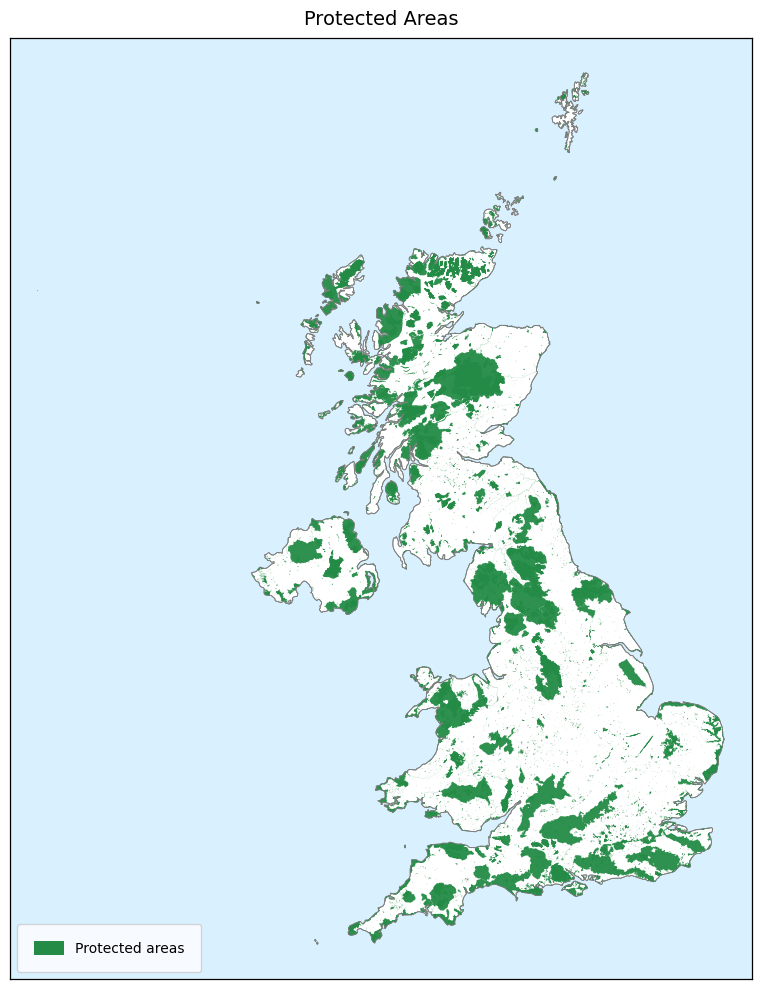

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8,10))
ax.set_facecolor("#d9f0ff")
uk_m.plot(ax=ax, facecolor="white", edgecolor="#7f7f7f", linewidth=0.6, zorder=1)
wdpa_uk.plot(ax=ax, color="#238b45", edgecolor="none", alpha=0.95, zorder=2)
uk_m.boundary.plot(ax=ax, edgecolor="#7f7f7f", linewidth=0.6, zorder=3)
ax.set_title("Protected Areas", fontsize=14, pad=10)
legend_elements = [
    Patch(facecolor="#238b45", edgecolor="none", label="Protected areas")]

leg = ax.legend(handles=legend_elements,loc="lower left",fontsize=10,frameon=True,borderpad=1.2,labelspacing=0.8,handlelength=2.2,handleheight=1.2)

minx, miny, maxx, maxy = uk_m.total_bounds
padx = (maxx - minx) * 0.04
pady = (maxy - miny) * 0.04
ax.set_xlim(minx - padx, maxx + padx)
ax.set_ylim(miny - pady, maxy + pady)
ax.set_aspect("equal", adjustable="box")

ax.set_xticks([]); ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(0.9)
    spine.set_edgecolor("black")

plt.tight_layout()
plt.show()
fig.savefig("Protected Areas.png", dpi=300, bbox_inches="tight")

In [8]:
TEMPLATE_TIF = "/Users/hester/Desktop/data/terrain.tif"

In [9]:
with rasterio.open(TEMPLATE_TIF) as src:
    meta = src.meta.copy()

In [10]:
with rasterio.open(TEMPLATE_TIF) as src:
    meta = src.meta.copy()
    transform = src.transform
    out_shape = (src.height, src.width)
    raster_crs = src.crs

uk_r = uk.to_crs(raster_crs)
wdpa_r = wdpa.to_crs(raster_crs)

wdpa_uk = gpd.clip(wdpa_r, uk_r)
wdpa_uk = wdpa_uk[wdpa_uk.geometry.notnull()].copy()

In [11]:
pa_mask = rasterize(
    [(geom, 1) for geom in wdpa_uk.geometry],
    out_shape=out_shape,
    transform=transform,
    fill=0,
    dtype="uint8",
    all_touched=True)

In [13]:
uk_mask = rasterize(
    [(geom, 1) for geom in uk_r.geometry],
    out_shape=out_shape,
    transform=transform,
    fill=0,
    dtype="uint8",
    all_touched=True)

In [14]:
NODATA = 255

prc = np.full(out_shape, NODATA, dtype="uint8")

inside_uk = (uk_mask == 1)

prc[(inside_uk) & (pa_mask == 0)] = 1

prc[(inside_uk) & (pa_mask == 1)] = 0

plot_arr = prc.astype("float32")
plot_arr[plot_arr == NODATA] = np.nan

In [15]:
OUT_PRC_BIN = r"/Users/hester/Desktop/data/prc_binary.tif"

meta_prc = meta.copy()
meta_prc.update(
    dtype="uint8",
    count=1,
    nodata=255,
    compress="lzw"
)

with rasterio.open(OUT_PRC_BIN, "w", **meta_prc) as dst:
    dst.write(prc, 1)

print("Saved:", OUT_PRC_BIN)

Saved: /Users/hester/Desktop/data/prc_binary.tif


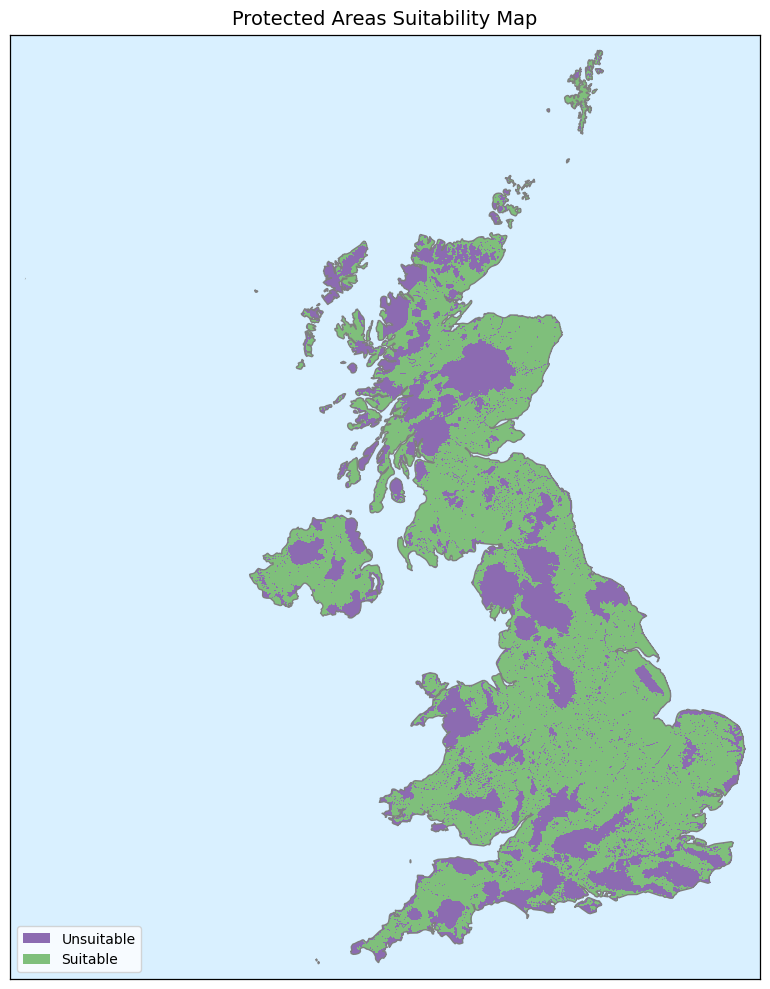

In [16]:
cmap = ListedColormap(["#8c6bb1", "#7fbf7b"]) 
norm = BoundaryNorm([-0.5, 0.5, 1.5], cmap.N) 

cmap2 = cmap.copy()         
cmap2.set_bad(alpha=0.0)

fig, ax = plt.subplots(1, 1, figsize=(8, 10))
ax.set_facecolor("#d9f0ff")

xmin = transform.c
ymax = transform.f
xmax = xmin + transform.a * out_shape[1]
ymin = ymax + transform.e * out_shape[0]

im = ax.imshow(
    plot_arr,
    extent=[xmin, xmax, ymin, ymax],
    origin="upper",
    cmap=cmap2,
    norm=norm,
    interpolation="nearest"
)

uk_r.boundary.plot(ax=ax, color="#7f7f7f", linewidth=1.0, zorder=3)

ax.set_title("Protected Areas Suitability Map", fontsize=14, pad=8)

legend_elements = [
    Patch(facecolor="#8c6bb1", edgecolor="none", label="Unsuitable"),
    Patch(facecolor="#7fbf7b", edgecolor="none", label="Suitable")
]
ax.legend(handles=legend_elements, loc="lower left", fontsize=10)
ax.set_xticks([]); ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(0.9)
    spine.set_edgecolor("black")

plt.tight_layout()
plt.show()
fig.savefig("Protected Areas Suitability Map.png", dpi=300, bbox_inches="tight")